In [1]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np
import datetime

import swyft
from utils import *
from plot import *

from tqdm import tqdm
from data_mgmt import get_paths, get_ids
import pickle
import pandas as pd




DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 15})



In [2]:
def restrictions(file, start, end):
    return (file.endswith(end) and file.startswith(start))

In [3]:
path = '../data/pred/'
files = os.listdir(path)
for file in files:
    if restrictions(file, 'pred_toy', 'pickle'):
        full_path = os.path.join(path, file)
        print(full_path)

../data/pred/pred_toy_m_1_nsub_2_nsim_1000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_2_nsim_1000_sigma_1.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_2_nsim_1000_sigma_0.1_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_3_nsim_10000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_3_nsim_10000_sigma_0.1_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_3_nsim_10000_sigma_1.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_3_nsim_10000_sigma_0.5_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_3_nsim_10000_sigma_2.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_3_nsim_10000_sigma_100.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_1_nsim_10000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_1_nsim_10000_sigma_0.1_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_1_nsim_10000_sigma_0.5_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_nsub_5_nsim_10000_sigma_0.0_nmc_1_npred_0.pickle
../data/pred/pred_toy_m_1_

In [4]:
m = 1
nsubs = [1, 3, 5, 10]
nsim = 10000
nmc = 1
npred = 0 #nsim
sigmas = [0.0, 0.1, 0.5] 
# sigmas = [0.0]
zero = 'toy'

entries = []
for nsub in nsubs:
    for sigma in sigmas:
        entry = dict(m=m,nsub=nsub,nsim=nsim,nmc=nmc,sigma=sigma,npred=npred,zero=zero)
        entries.append(entry)
    
#         print(entry)
n_entries = len(entries)
entries = np.array(entries)

entries = np.append(entries, dict(m=m,nsub=1,nsim=30000,nmc=nmc,sigma=0.0,npred=npred,zero=zero));

entries

array([{'m': 1, 'nsub': 1, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 1, 'nsim': 10000, 'nmc': 1, 'sigma': 0.1, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 1, 'nsim': 10000, 'nmc': 1, 'sigma': 0.5, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 0.1, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 3, 'nsim': 10000, 'nmc': 1, 'sigma': 0.5, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 5, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 5, 'nsim': 10000, 'nmc': 1, 'sigma': 0.1, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 5, 'nsim': 10000, 'nmc': 1, 'sigma': 0.5, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 10, 'nsim': 10000, 'nmc': 1, 'sigma': 0.0, 'npred': 0, 'zero': 'toy'},
       {'m': 1, 'nsub': 10, 'nsim': 10000, 'nmc': 1, 'sigma

In [5]:
def get_pred(entry):
    _, _, _, pred_path = get_paths(entry)
    
    with open(pred_path, 'rb') as f:
        pred = pickle.load(f)
        
    posts, targets, obs0s, v0s, obs0_is = list(pred.values())
    return posts, targets, obs0s, v0s, obs0_is

posts_all = []
targets_all = []
obs0s_all = []
v0s_all = []
obs0_is_all = []

for entry in entries:
    posts, targets, obs0s, v0s, obs0_is = get_pred(entry)
    
    posts_all.append(posts)
    targets_all.append(targets)
    obs0s_all.append(obs0s)
    v0s_all.append(v0s)
    obs0_is_all.append(obs0_is)
    

In [6]:
def get_f(posts, targets, x):
    
    x1, x2 = x[:-1], x[1:]
    
    def f3(xi, xj):
        y = targets[(posts > xi) & (posts < xj)]
        return y.sum() / len(y) if y.sum() != 0 else 0

    return np.array([f3(xi, xj) for xi, xj in zip(x1, x2)])

In [7]:
def get_tc(i, v0, target):
    y, x, m = v0.reshape(-1, 3).T
#     m_i = np.where(target == 1)[0]
#     target_coords = np.array((m_i, x, y)).T
    
    m_i = np.full(len(x), i)
    target_coords = np.array((m_i, x, y)).T

    return target_coords

def get_target_coords(i, v0s):
    return np.concatenate([get_tc(j, v0s[j], targets[j]) for j in range(i)])

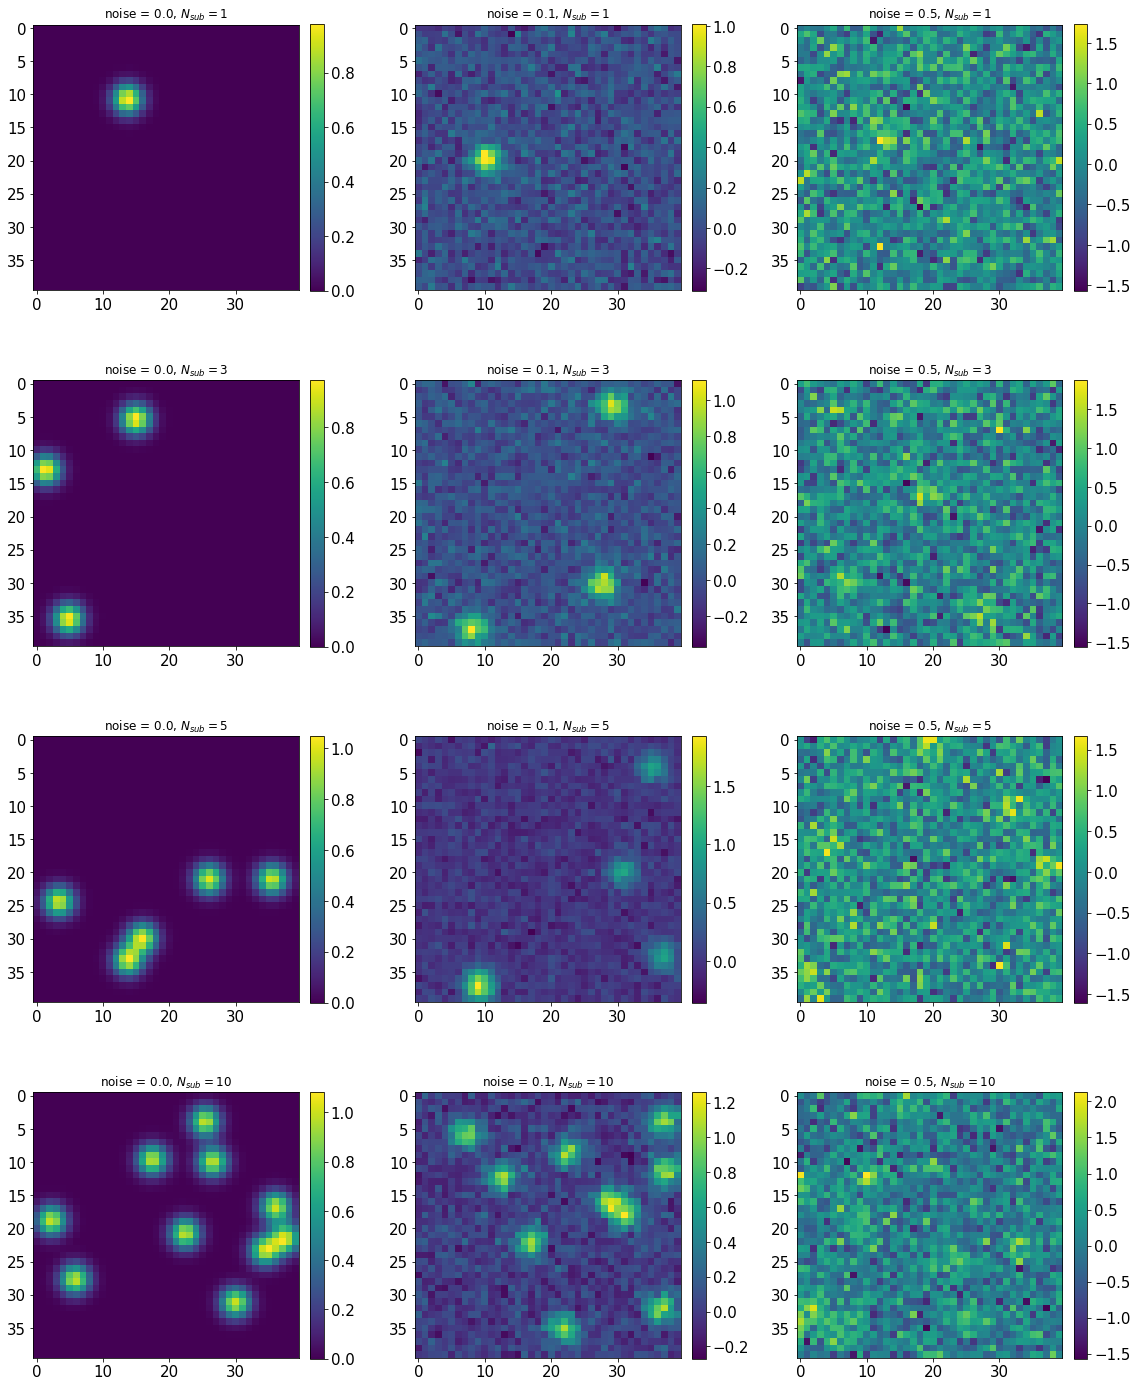

In [10]:
plt_imshow( np.array([obs0s[0] for obs0s in obs0s_all]),
           nrows = 4, y = 20,
           titles = [rf"noise = {entry['sigma']}, $N_{{sub}} = {entry['nsub']}$" for entry in entries[:-1]], 
           cbar = True, tl = True)

In [48]:
# def temp_prior(entries):
#     L = 40
#     priors =  [entry['nsub'] / (L*L) / entry['nmc']  for entry in entries]
#     assert all([prior == priors[0] for prior in priors])
#     return priors[0]
        
# prior_freq = temp_prior(entries)

def temp_prior(entry):
    L = 40
    prior = entry['nsub'] / (L*L) / entry['nmc']
    return prior
        
prior_freq = temp_prior(entry)

In [49]:
n_alpha = 50
alpha_edges = np.linspace(0, 1, n_alpha)
alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2

fs = np.array([get_f(posts, targets, alpha_edges) for posts, targets in zip(posts_all, targets_all)])

In [50]:
for posts, targets, entry in zip(posts_all, targets_all, entries):
    entry['f'] = get_f(posts, targets, alpha_edges) 

In [51]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [52]:
pd.DataFrame.from_records(entries)

,m,nsub,nsim,nmc,sigma,npred,zero,f
0,1,1,10000,1,0.0,0,toy,"[1.807534026984419e-05, 0.12433581296493093, 0..."
1,1,1,10000,1,0.1,0,toy,"[1.5794268027504066e-05, 0.08285264813843733, ..."
2,1,1,10000,1,0.5,0,toy,"[3.277890335048272e-05, 0.028876055086628164, ..."
3,1,3,10000,1,0.0,0,toy,"[2.4024326772560768e-05, 0.06888544891640867, ..."
4,1,3,10000,1,0.1,0,toy,"[3.365902323686116e-05, 0.06505075616324839, 0..."
5,1,3,10000,1,0.5,0,toy,"[9.614763537030009e-05, 0.030912847195653837, ..."
6,1,5,10000,1,0.0,0,toy,"[1.7091203213844823e-05, 0.04360679970436068, ..."
7,1,5,10000,1,0.1,0,toy,"[2.6736997463920826e-05, 0.045190648046445944,..."
8,1,5,10000,1,0.5,0,toy,"[0.0001502975644764201, 0.030497638939338902, ..."
9,1,10,10000,1,0.0,0,toy,"[2.3164826426836853e-05, 0.04292929292929293, ..."


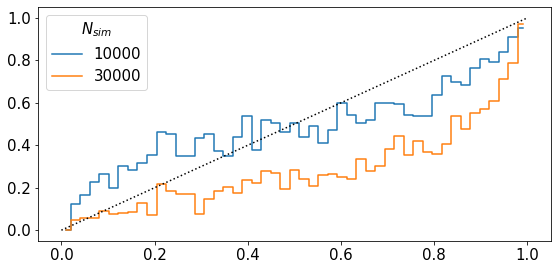

In [67]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4), tight_layout = True)

for entry in [entries[0], entries[-1]]:
    ax.step(alpha_centers, entry['f'], where = 'mid', label = entry['nsim'])
ax.plot([0, 1], [0, 1], "k:")
ax.legend(title = r'$N_{{sim}}$')

plt.show()

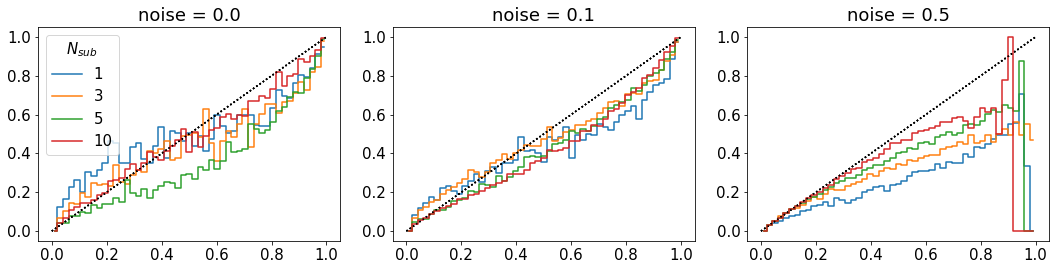

In [54]:
entries_reshape = np.reshape(np.array(entries[:-1]), (4, 3)).T

fig, axs = plt.subplots(1, 3, figsize = (15, 4), tight_layout = True)
for i, ax in enumerate(axs):
    for entry, color in zip(entries_reshape[i], colors):
        ax.step(alpha_centers, entry['f'], label = rf"{entry['nsub']}",
                where='mid', color = color)
        ax.set_title(f"noise = {entry['sigma']}")
        ax.plot([0, 1], [0, 1], "k:")

axs[0].legend(title = r'$N_{{sub}}$')

plt.show()


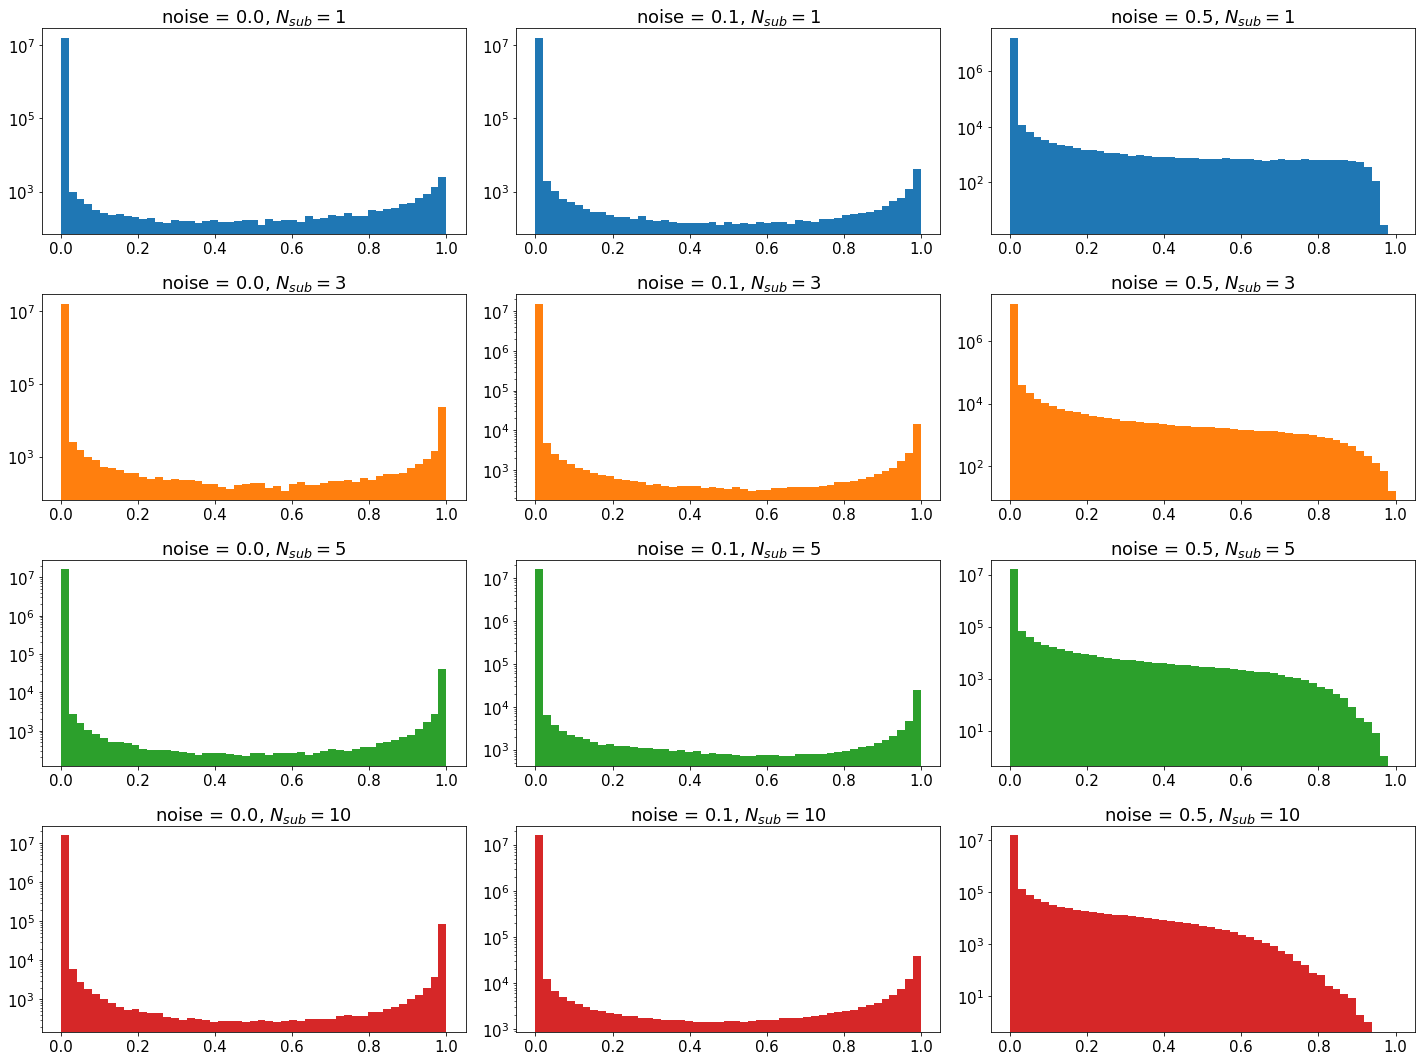

In [15]:
fig, axs = plt.subplots(4, 3, figsize = (20, 15), tight_layout = True)
axs = axs.flatten()

for ax, posts, entry, color in zip(axs, posts_all, entries, np.repeat(colors[:4], 3)):
    ax.hist(posts.flatten(), bins = alpha_edges, color = color)
    ax.set_title(rf"noise = {entry['sigma']}, $N_{{sub}} = {entry['nsub']}$")
    ax.set_yscale('log')
    